## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

## Import Required Libraries

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import os
%matplotlib inline 

## 1. Construct a function that can undistort images taken by the camera

In [2]:
def getCameraCalibrationParameters(calibration_images):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Step through the list and search for chessboard corners
    img = None
    
    for fname in calibration_images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            #Draw the corners and write image to file
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            head, tail = os.path.split(fname)
            write_name = './my_output/corners_found-'+tail[:-4]+'.jpg'
            cv2.imwrite(write_name,img)
    return objpoints,imgpoints,(img.shape[1],img.shape[0])

In [3]:
def makeUndistorter(objpoints,imgpoints,img_size):
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    def undistorter(img):
        return cv2.undistort(img,mtx,dist)
        
    return undistorter
    

In [4]:
# Make a list of calibration images
cal_images = glob.glob('./camera_cal/calibration*.jpg')

objpoints,imgpoints,cal_img_size = getCameraCalibrationParameters(cal_images)

# construct a function that can undistort images taken by the camera
undist = makeUndistorter(objpoints,imgpoints,cal_img_size)

## 2. Undistort a test chessboard image

In [5]:
# Test undistoring of the image
test_image_to_undistort = './camera_cal/calibration1.jpg'
img_undistored = undist(cv2.imread(test_image_to_undistort))
cv2.imwrite('./my_output/calibration1-undistorted.jpg',img_undistored)

True

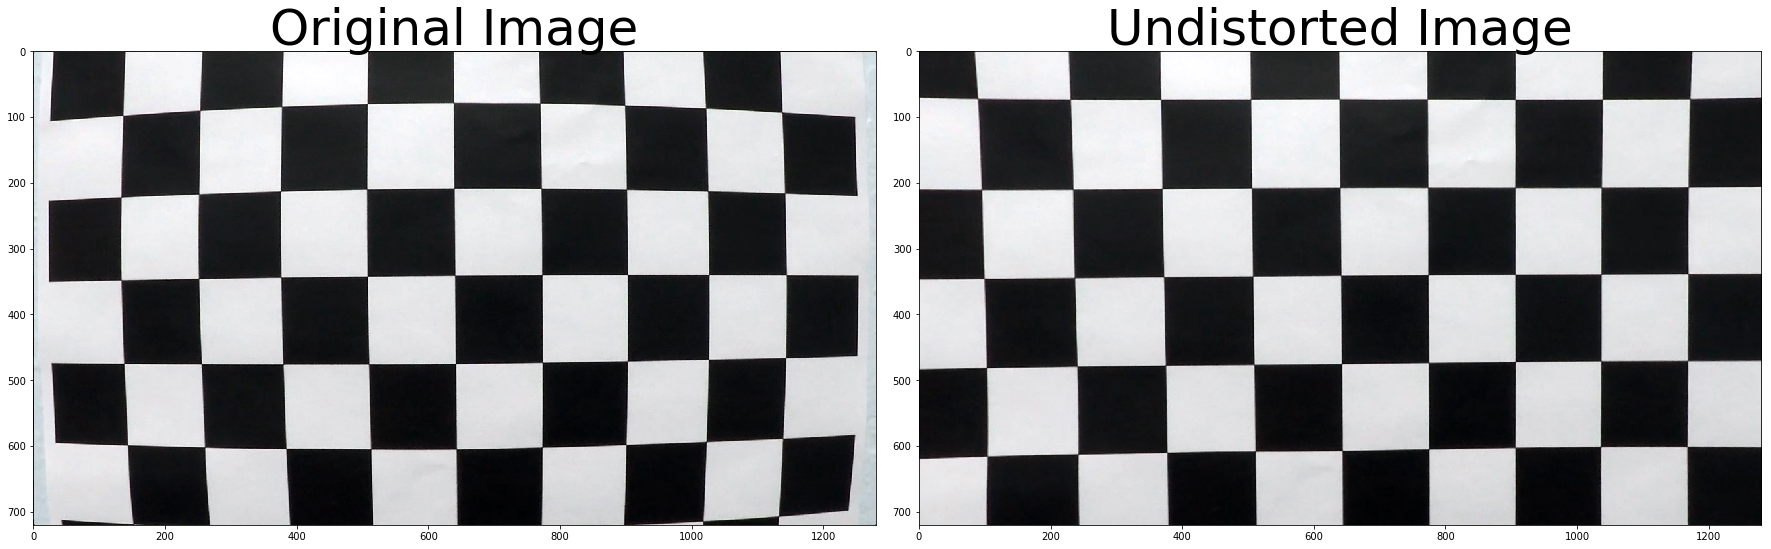

In [6]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.imread(test_image_to_undistort))
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(img_undistored)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 3. Undistort the road images in the Test folder

In [7]:
test_road_image_filenames = glob.glob('./test_images/*.jpg')
test_road_images = list(map(lambda x: cv2.imread(x),test_road_image_filenames))
test_road_images_undistorted = list(map(lambda z: undist(z) ,map(lambda x: cv2.imread(x),test_road_image_filenames)))

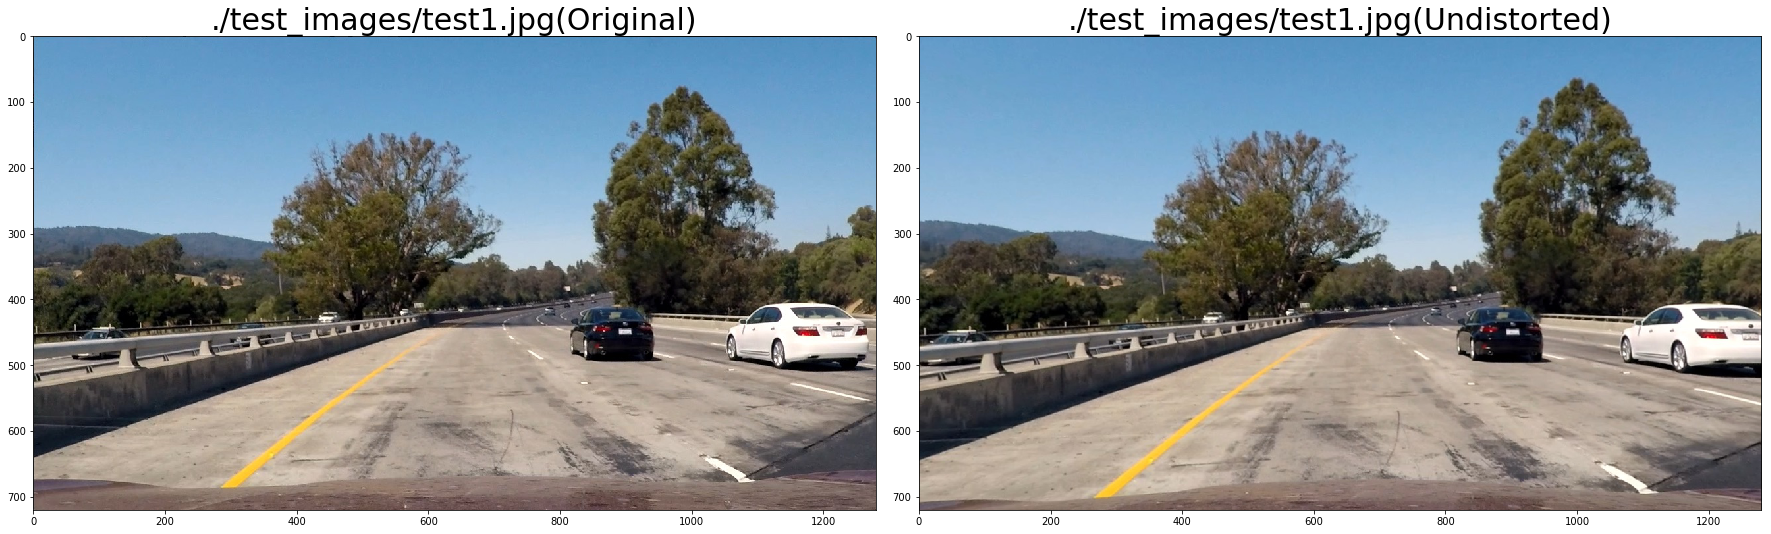

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(test_road_images[2], cv2.COLOR_BGR2RGB))
ax1.set_title(test_road_image_filenames[2]+'(Original)', fontsize=30)
ax2.imshow(cv2.cvtColor(test_road_images_undistorted[2], cv2.COLOR_BGR2RGB))
ax2.set_title(test_road_image_filenames[2]+'(Undistorted)', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 4. Create pipeline function to turn road images into binary

In [9]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [10]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def color_threshold(img, thresh=(0, np.pi/2)):
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hsv[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
   
    return s_binary

In [11]:
def pipeline(img, s_thresh=(115, 255), sx_thresh=(45, 200), sy_thresh=(65, 200),
             m_thresh=(84, 121),dir_thresh=(0.9, 1.0), ksize=3):
    
    image = np.copy(img)
    
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=sx_thresh)
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=sy_thresh)
    mag_binary = mag_thresh(image, sobel_kernel=ksize, thresh=m_thresh)
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=dir_thresh)
    color_binary = color_threshold(image, thresh=s_thresh)

    layered_binary = np.dstack((mag_binary, dir_binary, color_binary))
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (color_binary == 1)] = 1

    return layered_binary, combined

In [12]:
def showGrad(img, k_size=3, s_threshMin=220, s_threshMax=255, 
             sx_threshMin=20, sx_threshMax=100,sy_threshMin=20, sy_threshMax=100,
             mag_threshMin=20, mag_threshMax=100, dir_threshMin=20, dir_threshMax=100):
    
    result, result2 = pipeline(img,s_thresh=(s_threshMin,s_threshMax),
                                sx_thresh=(sx_threshMin,sx_threshMax),
                                sy_thresh=(sy_threshMin,sy_threshMax),
                                m_thresh=(mag_threshMin,mag_threshMax),
                                dir_thresh=(dir_threshMin,dir_threshMax), ksize=k_size)
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 12))
    #f.tight_layout()
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Undistorted', fontsize=10)
    ax2.imshow(result)
    ax2.set_title('Blue=Saturation Gradient, Green=Direction Gradient, Red=Magnitude Gradient', fontsize=10)
    ax3.imshow(result2, cmap='gray')
    ax3.set_title('Combined Gradients', fontsize=10)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

<function __main__.showGrad>

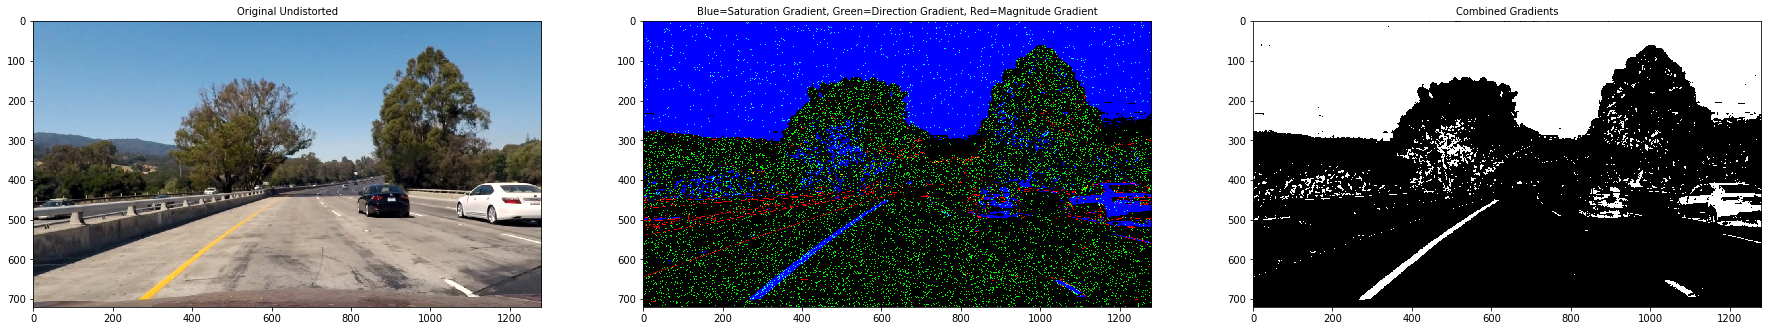

In [13]:
interact(showGrad, img=fixed(test_road_images_undistorted[2]), 
    s_threshMin=widgets.IntSlider(value=115,min=0,max=255,step=1,description='MinS:',continuous_update=False,), 
    s_threshMax=widgets.IntSlider(value=255,min=0,max=255,step=1,description='MaxS:',continuous_update=False,), 
    sx_threshMin=widgets.IntSlider(value=45,min=0,max=255,step=1,description='MinSx:',continuous_update=False,), 
    sx_threshMax=widgets.IntSlider(value=200,min=0,max=255,step=1,description='MaxSx:',continuous_update=False,),
    sy_threshMin=widgets.IntSlider(value=65,min=0,max=255,step=1,description='MinSy:',continuous_update=False,),
    sy_threshMax=widgets.IntSlider(value=200,min=0,max=255,step=1,description='MaxSy:',continuous_update=False,),
    mag_threshMin=widgets.IntSlider(value=84,min=0,max=255,step=1,description='MinMag:',continuous_update=False,),
    mag_threshMax=widgets.IntSlider(value=121,min=0,max=255,step=1,description='MaxMag:',continuous_update=False,),
    dir_threshMin=widgets.FloatSlider(value=0.8,min=0,max=np.pi/2,step=0.05,description='MinDir:',continuous_update=False,),
    dir_threshMax=widgets.FloatSlider(value=1.0,min=0,max=np.pi/2,step=0.05,description='MaxDir:',continuous_update=False,),
    k_size=widgets.IntSlider(value=3,min=1,max=31,step=2,description='Ksize:',continuous_update=False,),
)

## 5. Convert all test road images into binary

In [14]:
test_road_images_binary = list(map(lambda x: pipeline(x)[1],test_road_images_undistorted))

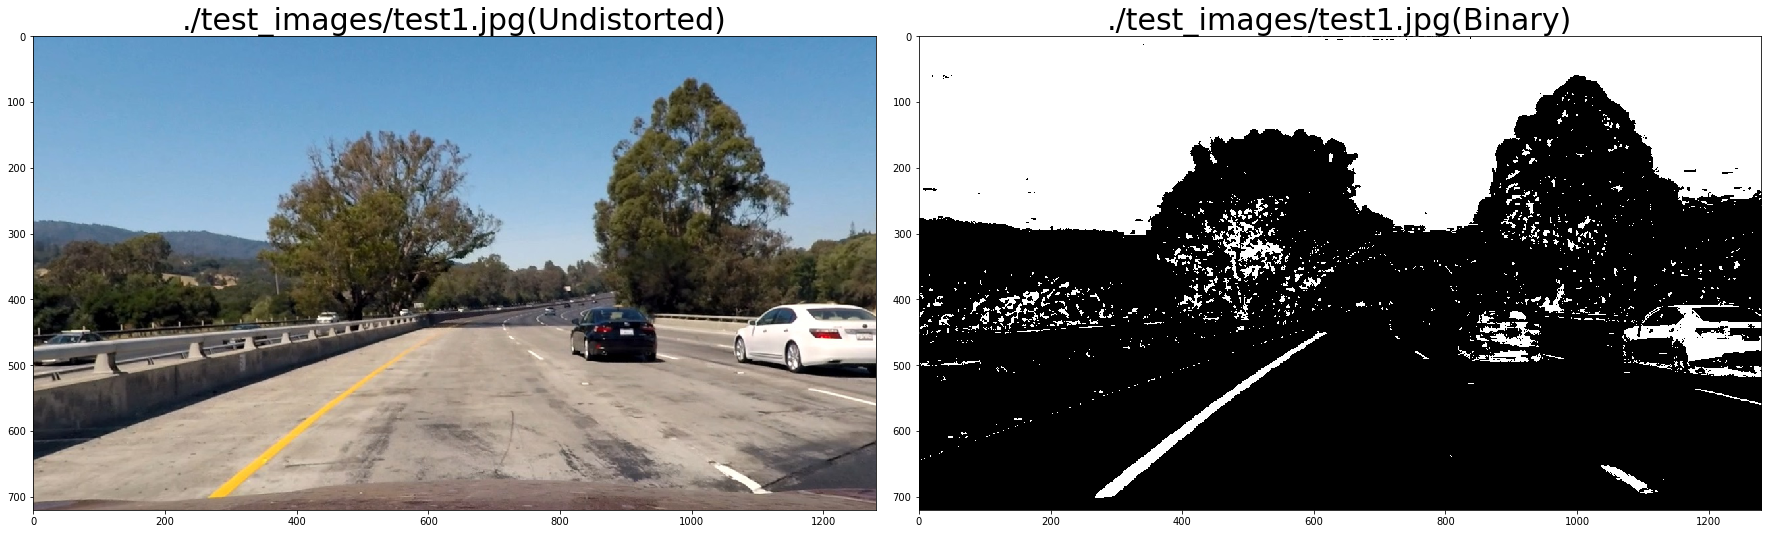

In [15]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(test_road_images_undistorted[2], cv2.COLOR_BGR2RGB))
ax1.set_title(test_road_image_filenames[2]+'(Undistorted)', fontsize=30)
ax2.imshow(test_road_images_binary[2], cmap='gray')
ax2.set_title(test_road_image_filenames[2]+'(Binary)', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 6. Generate warp transformation functions

In [21]:
def getWarpTransformers(image_to_warp,offsetX1=420,offsetY1=-230,offsetX2=-460,offsetY2=-230):
    x1 = 120
    y1 = image_to_warp.shape[0]-20
    x2 = image_to_warp.shape[1]-70
    y2 = image_to_warp.shape[0]-20
    
    src = np.float32([[x1, y1],[x2, y2],[x2+offsetX2, y2+offsetY2],[x1+offsetX1, y1+offsetY1]])
    dst = np.float32([[x1, y1],[x2, y2],[x2, y2-600],[x1, y1-600]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    return M, Minv, (x1,y1,x2,y2), (offsetX1,offsetY1,offsetX2,offsetY2)  

## 7. Test that the perspective transform works properly

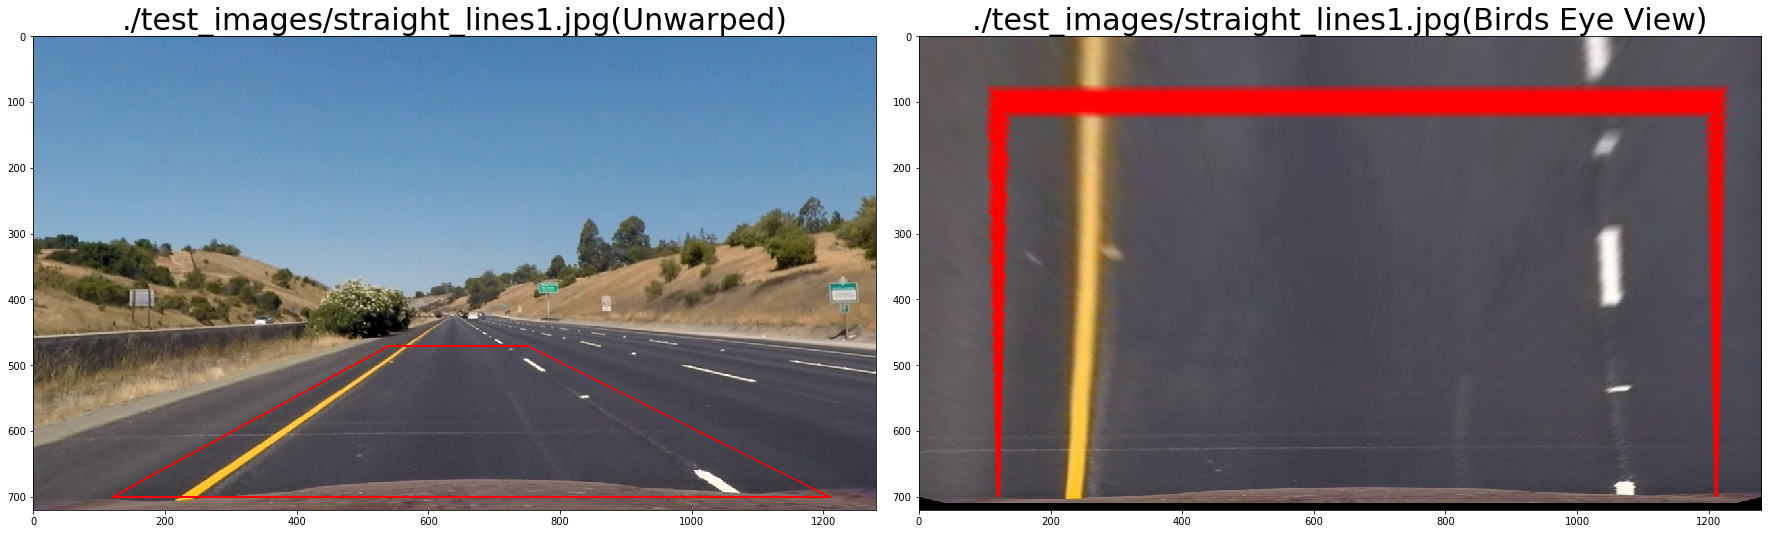

In [27]:
test_image_to_warp = np.copy(test_road_images_undistorted[1])

M, Minv, base_coords, offsets = getWarpTransformers(test_image_to_warp)

test_image_to_warp = np.copy(test_road_images_undistorted[0])
color=[0, 0, 255]
thickness=2
cv2.line(test_image_to_warp, (base_coords[0], base_coords[1]), (base_coords[2], base_coords[3]), color, thickness)
cv2.line(test_image_to_warp, (base_coords[0]+offsets[0], base_coords[1]+offsets[1]), (base_coords[2]+offsets[2], base_coords[3]+offsets[3]), color, thickness)
cv2.line(test_image_to_warp, (base_coords[0], base_coords[1]), (base_coords[0]+offsets[0], base_coords[1]+offsets[1]), color, thickness)
cv2.line(test_image_to_warp, (base_coords[2], base_coords[3]), (base_coords[2]+offsets[2], base_coords[3]+offsets[3]), color, thickness)


image_to_warp_size = (test_image_to_warp.shape[1],test_image_to_warp.shape[0])
test_image_warped = cv2.warpPerspective(test_image_to_warp, M, image_to_warp_size, flags=cv2.INTER_LINEAR)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(test_image_to_warp, cv2.COLOR_BGR2RGB))
ax1.set_title(test_road_image_filenames[0]+'(Unwarped)', fontsize=30)
ax2.imshow(cv2.cvtColor(test_image_warped, cv2.COLOR_BGR2RGB))
ax2.set_title(test_road_image_filenames[0]+'(Birds Eye View)', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 8. Create function that generates lane overlay

In [107]:
def getOverlay(input_img):   
    M, Minv,_,_ = getWarpTransformers(input_img)
    img_size = (input_img.shape[1],input_img.shape[0])
    binary_warped = cv2.warpPerspective(input_img, M, img_size, flags=cv2.INTER_LINEAR)
    
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
#     plt.imshow(out_img)
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
#     plt.xlim(0, 1280)
#     plt.ylim(720, 0)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, img_size)
    
    y_eval = np.max(ploty)
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(newwarp,'Left Curve = '+str(left_curverad)+' m',(10,80), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(newwarp,'Right Curve = '+str(right_curverad)+' m',(10,120), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(newwarp,'Center offset = something',(10,160), font, 1,(255,255,255),2,cv2.LINE_AA)
    return newwarp,(out_img,left_fitx,right_fitx,ploty)

## 9. Test that the overlay generation works properly

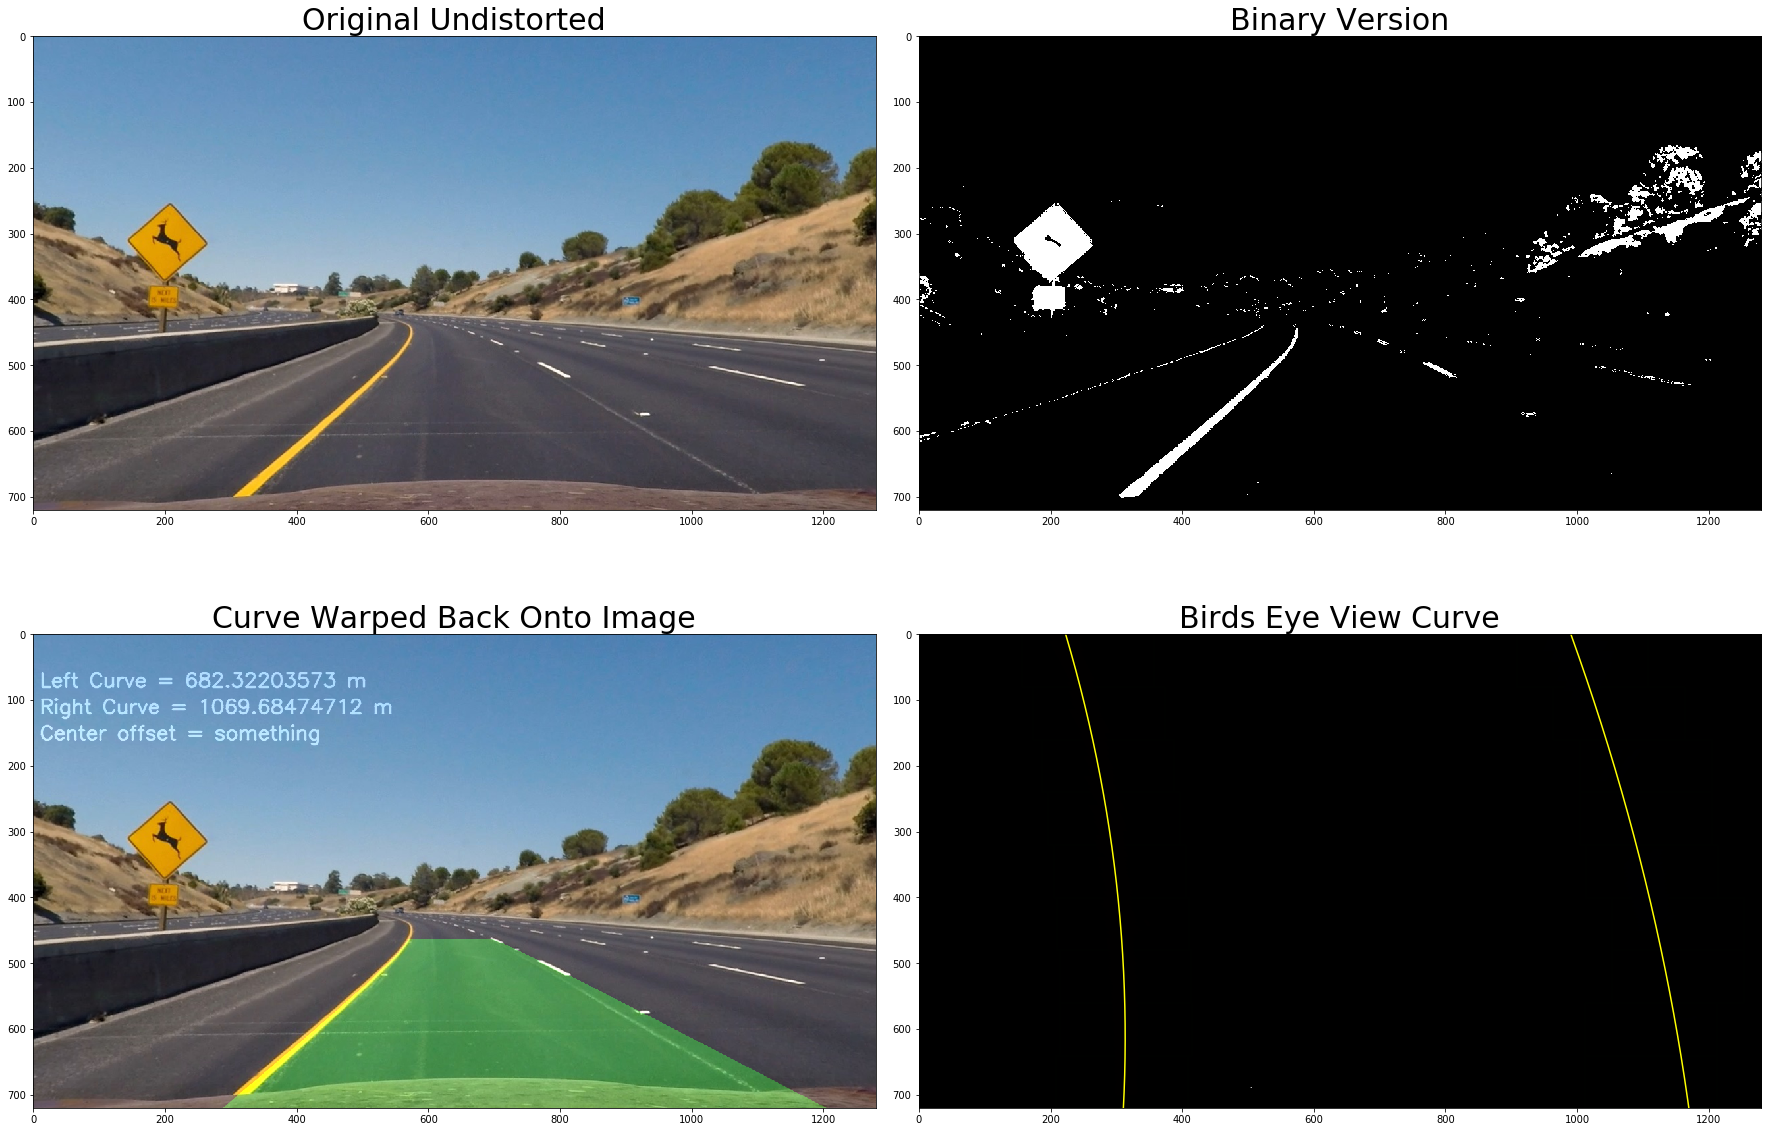

In [108]:
test_image_for_overlay = np.copy(test_road_images_undistorted[3])
test_image_for_overlay_binary = pipeline(test_image_for_overlay)[1]

view1,view2 = getOverlay(test_image_for_overlay_binary)

view1 = cv2.addWeighted(test_image_for_overlay, 1, view1, 0.3, 0)
f, axes = plt.subplots(2, 2, figsize=(24, 18))
f.tight_layout()
axes[0,0].imshow(cv2.cvtColor(test_image_for_overlay, cv2.COLOR_BGR2RGB))
axes[0,0].set_title('Original Undistorted', fontsize=30)
axes[0,1].imshow(test_image_for_overlay_binary,cmap='gray')
axes[0,1].set_title('Binary Version', fontsize=30)
axes[1,0].imshow(cv2.cvtColor(view1, cv2.COLOR_BGR2RGB))
axes[1,0].set_title('Curve Warped Back Onto Image', fontsize=30)
#axes[1,1].imshow(view2)
#axes[1,1].set_title('View2', fontsize=30)

axes[1,1].imshow(view2[0])
axes[1,1].set_title('Birds Eye View Curve', fontsize=30)
axes[1,1].plot(view2[1], view2[3], color='yellow')
axes[1,1].plot(view2[2], view2[3], color='yellow')

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 10. Create a function that stitches together the entire image processing pipeline 

In [100]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    result = undist(image)
    result = pipeline(result)
    result = getOverlay(result[1])[0]
    result = cv2.addWeighted(image, 1, result, 0.3, 0)
    return result

In [101]:
import imageio
#imageio.plugins.ffmpeg.download()
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [102]:
test_video1 = './my_output/test_video1-2.mp4'
clip1 = VideoFileClip("project_video.mp4")
test_video1_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time test_video1_clip.write_videofile(test_video1, audio=False)

[MoviePy] >>>> Building video ./my_output/test_video1-2.mp4
[MoviePy] Writing video ./my_output/test_video1-2.mp4



100%|█████████▉| 1260/1261 [06:04<00:00,  3.69it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./my_output/test_video1-2.mp4 

CPU times: user 5min 58s, sys: 24.5 s, total: 6min 23s
Wall time: 6min 6s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_video1))

In [ ]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

In [ ]:
print(right_fitx.shape)

In [ ]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

In [ ]:
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

In [ ]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
And you're done! But let's visualize the result here as well
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [ ]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

### Sanity Check

Ok, so your algorithm found some lines. Before moving on, you should check that the detection makes sense. To confirm that your detected lane lines are real, you might consider:


Checking that they have similar curvature
Checking that they are separated by approximately the right distance horizontally
Checking that they are roughly parallel

## 7. Fit a second order polynomial to the lane markings

## 8. Do sanity check on the predicted lines

## 9. Apply average of previous predictions

## 10. Calculate curvature and distance from lane center

## 11. Warp back to original perspective and overlay lane predictions